<a href="https://colab.research.google.com/github/Bappy60/ML_Assignment/blob/main/Final%20Lab%20Problem%201/X_ray_image_classification_with_CNN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import cv2
import random
import os
import glob
import albumentations as A
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout , BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
!pip install google-colab
import google.colab.drive as drive

#Loading the Dataset



In [10]:
drive.mount('/content/drive')
!unzip "/content/drive/My Drive/Archive.zip"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/My Drive/Archive.zip
replace test/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Cheking the dataset

In [ ]:
!ls -l

In [ ]:
!ls -l train/NORMAL

##Loading data into variable


In [37]:
train_data = glob.glob('train/**/*.jpeg')
test_data = glob.glob('test/**/*.jpeg')
val_data = glob.glob('val/**/*.jpeg')
print("〰"*20)
print(f"Training Set has: {len(train_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print(f"Validation Set has: {len(val_data)} images")
print("〰"*20)

〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
Training Set has: 5216 images
Testing Set has: 624 images
Validation Set has: 16 images
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰


#Data Exploration

In [44]:
!ls -l /content

total 24
drwx------ 5 root root 4096 Jan 17 16:38 drive
drwxr-xr-x 4 root root 4096 Jan 17 16:38 __MACOSX
drwxr-xr-x 1 root root 4096 Jan 12 19:20 sample_data
drwxr-xr-x 4 root root 4096 Jan  8 17:16 test
drwxr-xr-x 4 root root 4096 Jan  8 17:16 train
drwxr-xr-x 4 root root 4096 Jan  8 17:16 val


In [45]:
DIR = "/content"
sets = ["train", "test", "val"]
all_pneumonia = []
all_normal = []

for cat in sets:
    path = os.path.join(DIR, cat)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)
print("〰"*20)
print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")
print("〰"*20)

〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
Total Pneumonia Images: 4273
Total Normal Images: 1583
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰


In [47]:
train_dir="train"
test_dir="test"
val_dir="val"


print("Train set:\n========================================")
num_pneumonia=len(os.listdir(os.path.join(train_dir,'PNEUMONIA')))
num_normal=len(os.listdir(os.path.join(train_dir,'NORMAL')))

print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

Train set:
PNEUMONIA=3875
NORMAL=1341
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=8
NORMAL=8


In [46]:
## Plotly chart for Class distribution
labels = ["Normal",'Pneumonia ']
values = [len(all_normal), len(all_pneumonia)]
colors = ['green', 'pink']
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values,hole=.5)])
fig.update_traces(hoverinfo='value', textinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=3)))
fig.update_layout(title="Image Category Distribution",
                  titlefont={'size': 30},
                  )
iplot(fig)

#Data Visualization & Preprocessing


In [49]:
# Initialize the ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=False,
    rotation_range=0.3,
    zoom_range=0.4
)

# Initialize the ImageDataGenerator for validation and test data (without data augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from the train directory
train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(150, 150),  # adjust to the input size of your model
    batch_size=32,  # adjust based on your requirements
    class_mode='binary'  # or 'categorical' for multi-class problems
)

# Load images from the validation directory
val_generator = val_test_datagen.flow_from_directory(
    'val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Load images from the test directory
test_generator = val_test_datagen.flow_from_directory(
    'test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


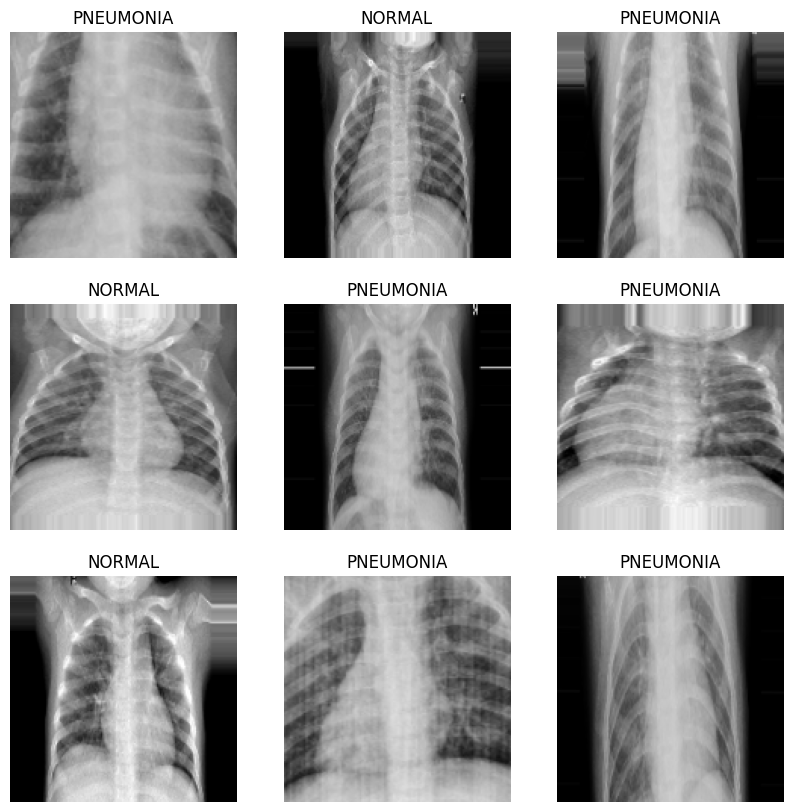

In [55]:
# Get a batch of images and labels
images, labels = next(train_generator)

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Plot the images with their labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_labels[int(labels[i])])  # map numeric labels to class names
    plt.axis('off')
plt.show()